In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datetime import datetime
import dateparser
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import pmdarima as pm
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

#reading file, not standart delimeter, providing it(;) to pandas
df1=pd.read_csv('../datasets/household_power_consumption.txt', delimiter=';', index_col=["Date"], parse_dates=["Date"])

#rewriting to read from excel
#df.to_csv('../temp/timeser.csv',encoding='utf-16', sep='\t', index=False)
df1.dtypes

Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("R2 score = ", r2_score(y_true, y_pred))
    print("MAE = ", mean_absolute_error(y_true, y_pred))
    print("MedianAE = ", median_absolute_error(y_true, y_pred))
    print("MSE = ", mean_squared_error(y_true, y_pred))
    print("MAPE = ", mean_absolute_percentage_error(y_true, y_pred))

In [7]:
df_real=df1.copy(deep=True)




df_real[['Global_active_power','Global_reactive_power']]=df_real[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_real['Total_power']=(df_real['Global_active_power']**2+df_real['Global_reactive_power']**2)**0.5

df_real=df_real.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
df_real



,Total_power
Date,
2006-12-16,4.236671
2006-12-16,5.377704
2006-12-16,5.397025
2006-12-16,5.411335
2006-12-16,3.703828
...,...
2010-11-26,0.946000
2010-11-26,0.944000
2010-11-26,0.938000


In [8]:
df_real=df_real.groupby(by=['Date']).mean()
#df_real.loc['2007-01-01']
df_real.info()
#print(df_real.dropna().count())
#print(df_real.count())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [9]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   

In [10]:
df_real['Total_power']=df_real['Total_power'].interpolate(method='time')
df_real.reset_index(inplace=True)
date = pd.DatetimeIndex(df_real['Date'])
df_real.drop(columns='Date', inplace=True)
df_real.set_index(date, inplace=True)
df_real.index.name = 'Date'
df_real=df_real.asfreq('d')

In [11]:
df_real.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Date', length=1442, freq='D')

In [12]:
ADF_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   -3.710666
p-value                           0.003966
Lags Used                        22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


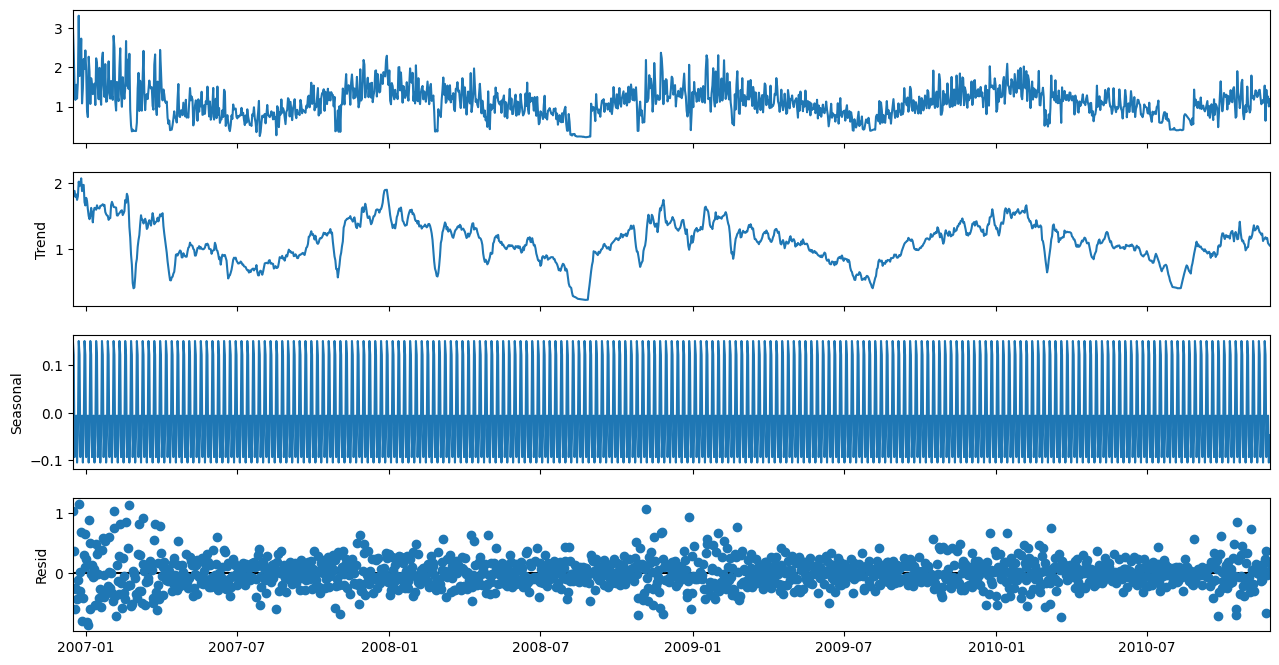

In [13]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df_real)

In [14]:
train_data = df_real['Total_power'][:int(len(df_real)*0.8)]
test_data = df_real['Total_power'][int(len(df_real)*0.8):]


In [15]:
stepwise_fit = auto_arima(df_real, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 7, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=526.951, Time=3.95 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1408.166, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=914.142, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=720.744, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1406.252, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=1229.939, Time=0.38 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=528.910, Time=4.55 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=893.856, Time=0.79 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=530.510, Time=4.57 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=640.137, Time=1.19 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=508.374, Time=3.03 sec
 ARIMA(2,0,1)(0,1,0)[7] intercept   : AIC=1230.866, Time=0.45 sec
 ARIMA(2,0,1)(1,1,1)[7] intercept   : AIC=509.869, Time=2.40 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : AIC=517.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1442
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 7)   Log Likelihood                -238.648
Date:                             Thu, 15 Jun 2023   AIC                            493.297
Time:                                     23:16:09   BIC                            535.448
Sample:                                 12-16-2006   HQIC                           509.034
                                      - 11-26-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1472      0.086      1.705      0.088      -0.022       0.316
ar.L2          0.0596      0.079      0.755      0.450      -0.095       0.214
ar.L3          0.6896      0.056     12.380      0.000       0.580       0.799
ma.L1          0.2025      0.085      2.383      0.017       0.036       0.369
ma.L2          0.0587      0.066      0.886      0.376      -0.071       0.189
ma.L3         -0.5138      0.047    -10.866      0.000      -0.607      -0.421
ma.S.L7       -0.9250      0.011    -84.297      0.000      -0.947      -0.904
sigma2         0.0810      0.002     39.627      0.000       0.077       0.085
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               505.27
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
n_periods = 31

# Make the forecast
forecast, conf_int = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True)

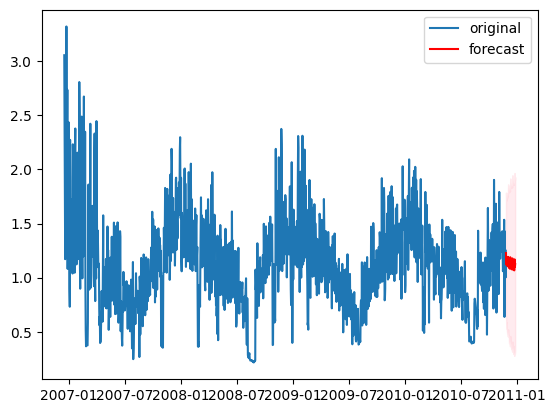

In [24]:


# Create a range of future dates that is the length of the periods we've forecasted
future_dates = pd.date_range('2010-11-26', periods=n_periods, freq='D')

# Plot the original data
plt.plot(df_real.index, df_real['Total_power'], label='original')

# Plot the forecasted data
plt.plot(future_dates, forecast, color='red', label='forecast')

# Shade the area between the confidence lower and upper limits
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()
